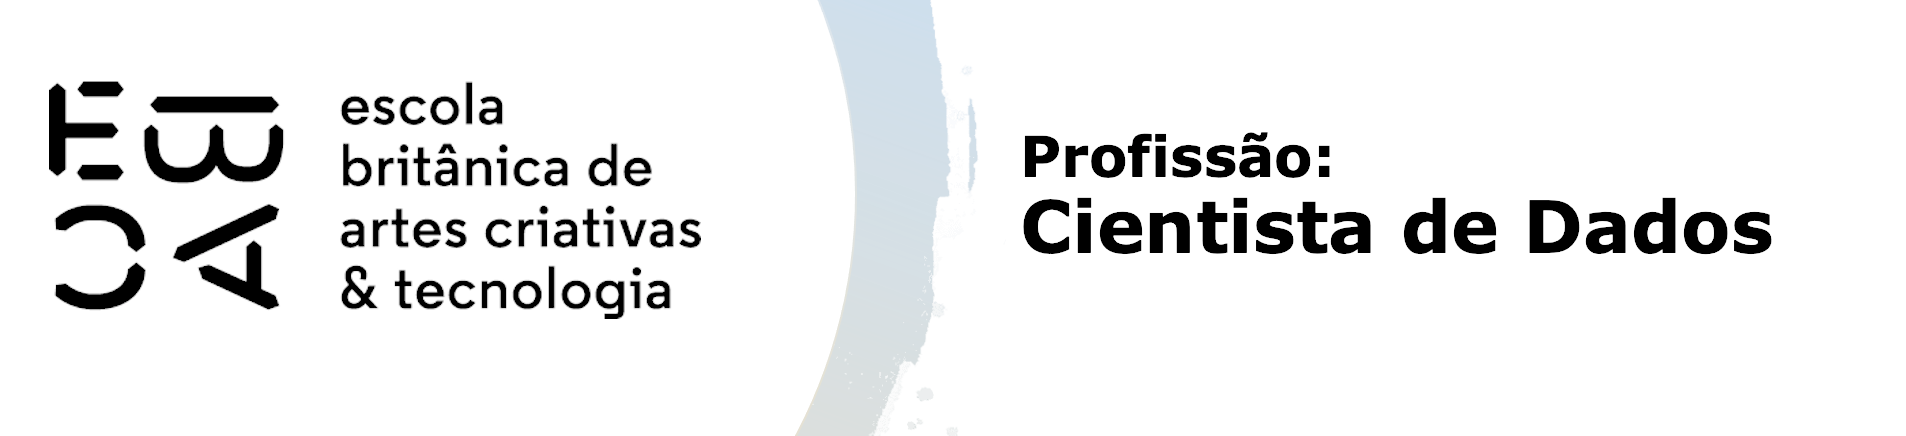

# Métodos hierárquicos de agrupamento

## Algoritmo

Vamos discutir o algoritmo e rodar passo a passo, para podermos ter uma sensibilidade e uma ideia intuitiva do seu funcionamento. Tipicamente esse entendimento ajuda muito a entendermos as diferenças entre algoritmos, suas características, quando roda bem e quando não, e por fim, ajuda a decidir qual algoritmo usar no problema que temos na nossa frente.

A ideia básica do algoritmo é a seguinte:

1. Calcular as distâncias para todos os pares de pontos da nossa tabela. Isso significa calcular $(n^2-n)/2$ distâncias.<br>
    Calcular todas as distâncias significa calcular uma matriz de distâncias entre cada par de pontos. A matriz de distâncias vai ter essa cara:

<div>
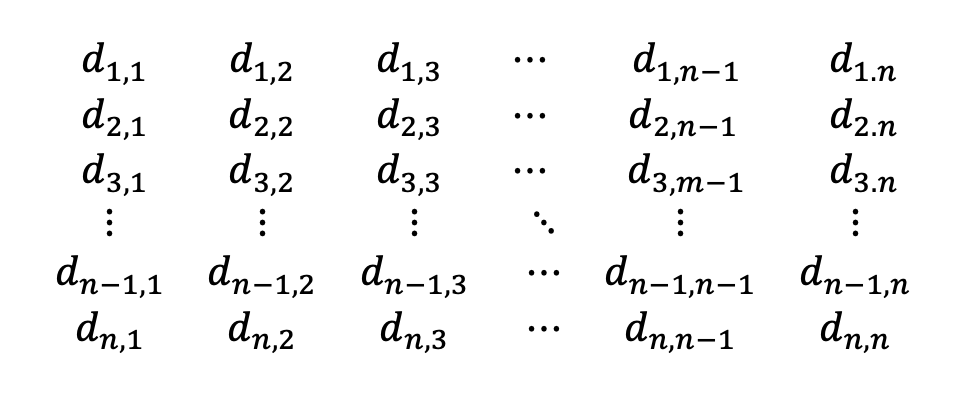
</div>
em que $d_{i, j}$ é a distância entre o ponto i e o ponto j.
<br>

2. Encontrar a menor distância <br>
    $d_{min} = min_{i, j}(d_{i,j}) $ <br>
    com $i \ne j$<br><br>

3. Agrupar o par correspondente à menor distância. Ou seja, recalcular as distâncias desse novo 'ponto' a todos os demais.

<div>
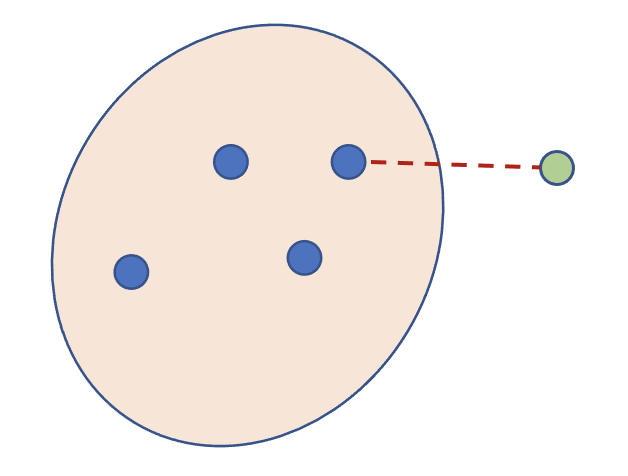
</div>

3. Repetir 2 e 3 até agrupar todos os elementos em um grande agrupamento.




Repare que como $d_{i, j}$ = $d_{j, i}$, a matriz de distâncias fica com essa cara:

<div>
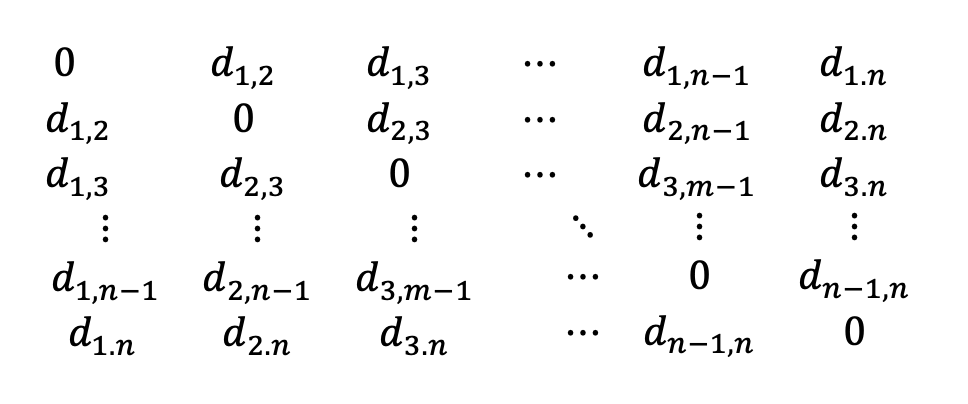
</div>

In [1]:
import time as time
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance

sns.set_theme()

%reload_ext watermark
%watermark -iv -v -p python-dateutil

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

python-dateutil: not installed

scipy     : 1.11.4
matplotlib: 3.8.2
seaborn   : 0.13.0
numpy     : 1.26.2
pandas    : 2.1.3



## Gerando os dados

Vamos começar gerando 12 pontos com variáveis ```x``` e ```y```, com um agrupamento natural identificavel visualmente. Vamos fazer o gráfico passo a passo para ir acompanhando o algoritmo.

In [2]:
## Gerar os dados
np.random.seed(2360873)
x = np.random.normal([1, 2, 3]*4,.2,12)
y = np.random.normal([0, 2, 0]*4,.2,12)
pontos = pd.DataFrame(np.c_[x,y], columns = ['x', 'y'])
pontos

,x,y
0,0.808025,0.002214
1,1.836726,1.864276
2,3.144988,0.150698
3,1.185140,-0.074400
4,2.135976,2.195185
5,2.707983,0.015969
6,0.989527,0.187312
7,1.795878,1.957112
8,2.496841,0.041325
9,0.965620,0.339734


## Fazer o gráfico

Vamos fazer o gráfico, identificando cada ponto pelo rótulo, dando uma cor para cada grupo. Inicialmente, cada ponto pertence a seu próprio grupo, então teremos 12 cores.

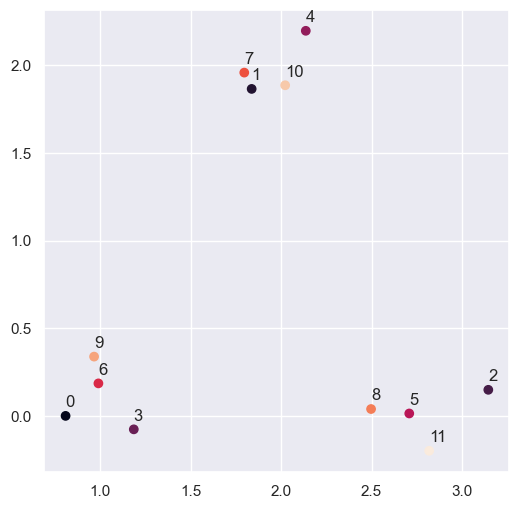

In [3]:
# Fazer o gráfico
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)

cores = pontos.index.values
ax.scatter(pontos['x'], pontos['y'], c=cores)

for idx, col in pontos.iterrows():
     ax.annotate(idx, (col['x'], col['y']+.05) )

## Calcular as distâncias

Vamos calcular as distâncias para todos os pares de pontos.

In [4]:
d = pd.DataFrame(distance.cdist(pontos, pontos, 'euclidean'))

## Menor distância

Vamos identificar os dois pontos mais próximos através da menor distância entre eles.

In [5]:
D = d[d!=0].copy()
D.style.highlight_min(axis = None).format(precision=2, decimal=',')

,0,1,2,3,4,5,6,7,8,9,10,11
0,nan,"2,13","2,34","0,38","2,56","1,90","0,26","2,19","1,69","0,37","2,24","2,02"
1,"2,13",nan,"2,16","2,05","0,45","2,04","1,88","0,10","1,94","1,76","0,19","2,28"
2,"2,34","2,16",nan,"1,97","2,28","0,46","2,16","2,25","0,66","2,19","2,07","0,48"
3,"0,38","2,05","1,97",nan,"2,46","1,53","0,33","2,12","1,32","0,47","2,13","1,64"
4,"2,56","0,45","2,28","2,46",nan,"2,25","2,31","0,42","2,18","2,19","0,33","2,49"
5,"1,90","2,04","0,46","1,53","2,25",nan,"1,73","2,14","0,21","1,77","1,99","0,24"
6,"0,26","1,88","2,16","0,33","2,31","1,73",nan,"1,94","1,51","0,15","1,99","1,87"
7,"2,19","0,10","2,25","2,12","0,42","2,14","1,94",nan,"2,04","1,82","0,24","2,38"
8,"1,69","1,94","0,66","1,32","2,18","0,21","1,51","2,04",nan,"1,56","1,90","0,40"
9,"0,37","1,76","2,19","0,47","2,19","1,77","0,15","1,82","1,56",nan,"1,87","1,93"


## Agrupar os elementos respectivos

Para agrupar os elementos, vamos identificar os índices e "recalcular" a matriz de distâncias. Claro que não precisamos recalcular tudo, mas somente as distâncias ao novo elemento agrupado. Há várias formas de fazer esse cálculo que é o que chamamos de **método de agregação**. Vamos utilizar um bastante popular que é o ***complete linkage*** (ou ligação completa), que consiste em definir a distância de um ponto qualquer $p_j$ à unidade recém agregada como o mínimo entre as distância entre o ponto $p_j$ e cada um dos pontos da unidade agregada.

In [6]:
D.min().min()

0.10142537250432097

In [7]:
# Identificar índices dos elementos a serem agrupados
juntar = set(D.loc[:,D.min() == D.min().min()].columns)
juntar

{1, 7}

## Gráfico intermediário

O gráfico abaixo vai mostrar como 'está' o agrupamento neste passo, agora devemos ter uma cor a menos, pois dois pontos vão estar agrupados.

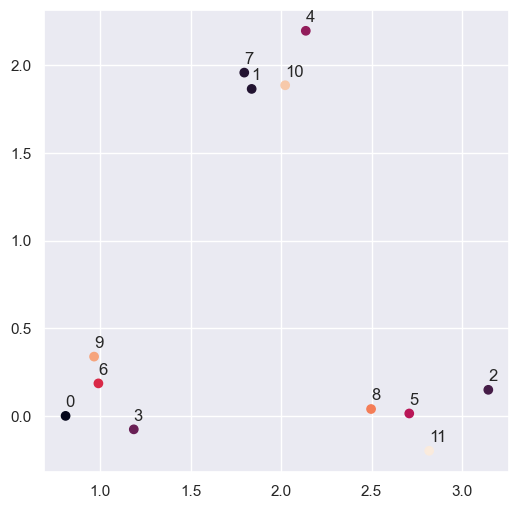

In [8]:
cores[(cores == max(juntar)) | (cores == min(juntar))] = min(juntar)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(pontos['x'], pontos['y'], c=cores)

for idx, col in pontos.iterrows():
     ax.annotate(idx, (col['x'], col['y']+.05) )

## Matriz de distâncias

Calcular novamente a matriz de distâncias e encontrar o *próximo* para a ser agregado.

In [9]:
D.loc[:,min(juntar)] = d[list(juntar)].min(axis=1)
D.loc[min(juntar)] = d[list(juntar)].min(axis=1).replace(0,np.nan)
D.drop(columns = juntar - {min(juntar)}, index = juntar - {min(juntar)}, inplace=True)

D.style.highlight_min(axis=None)

,0,1,2,3,4,5,6,8,9,10,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238,1.689269,0.372500,2.240290,2.019802
1,2.127323,nan,2.155898,2.045245,0.415145,2.043361,1.878817,1.938788,1.755863,0.186419,2.282617
2,2.341675,2.155898,nan,1.972732,2.279919,0.457302,2.155771,0.657310,2.187550,2.066217,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737,1.316796,0.468717,2.130701,1.637443
4,2.563704,0.415145,2.279919,2.460712,nan,2.253036,2.312120,2.183881,2.193725,0.330387,2.487178
5,1.900008,2.043361,0.457302,1.525522,2.253036,nan,1.726977,0.212659,1.772188,1.991030,0.239403
6,0.259238,1.878817,2.155771,0.326737,2.312120,1.726977,nan,1.514366,0.154286,1.987058,1.868365
8,1.689269,1.938788,0.657310,1.316796,2.183881,0.212659,1.514366,nan,1.560027,1.903930,0.399730
9,0.372500,1.755863,2.187550,0.468717,2.193725,1.772188,0.154286,1.560027,nan,1.871900,1.928489
10,2.240290,0.186419,2.066217,2.130701,0.330387,1.991030,1.987058,1.903930,1.871900,nan,2.228744


## Função

Como vamos repetir esses passos diversas vezes, vamos transformá-los em funções para facilitar a nossa vida.

In [10]:
def acha_indice(D, pontos, cores):
    juntar = set(D.loc[:,D.min() == D.min().min()].columns)

    cores[(cores == max(juntar)) | (cores == min(juntar))] = min(juntar)

    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(pontos['x'], pontos['y'], c=cores)

    for idx, col in pontos.iterrows():
         ax.annotate(idx, (col['x'], col['y']+.05) )
    print(juntar)

    return juntar



In [11]:
def agrupar(D, d, juntar):
    D.loc[:,min(juntar)] = d[list(juntar)].min(axis=1)
    D.loc[min(juntar)] = d[list(juntar)].min(axis=1).replace(0,np.nan)
    D.drop(columns = juntar - {min(juntar)}, index = juntar - {min(juntar)}, inplace=True)

    display(D.style.highlight_min(axis=None))
    return D


### Passo 2

{9, 6}


,0,1,2,3,4,5,6,8,10,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238,1.689269,2.240290,2.019802
1,2.127323,nan,2.155898,2.045245,0.415145,2.043361,1.755863,1.938788,0.186419,2.282617
2,2.341675,2.155898,nan,1.972732,2.279919,0.457302,2.155771,0.657310,2.066217,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737,1.316796,2.130701,1.637443
4,2.563704,0.415145,2.279919,2.460712,nan,2.253036,2.193725,2.183881,0.330387,2.487178
5,1.900008,2.043361,0.457302,1.525522,2.253036,nan,1.726977,0.212659,1.991030,0.239403
6,0.259238,1.755863,2.155771,0.326737,2.193725,1.726977,nan,1.514366,1.871900,1.868365
8,1.689269,1.938788,0.657310,1.316796,2.183881,0.212659,1.514366,nan,1.903930,0.399730
10,2.240290,0.186419,2.066217,2.130701,0.330387,1.991030,1.871900,1.903930,nan,2.228744
11,2.019802,2.282617,0.477036,1.637443,2.487178,0.239403,1.868365,0.399730,2.228744,nan


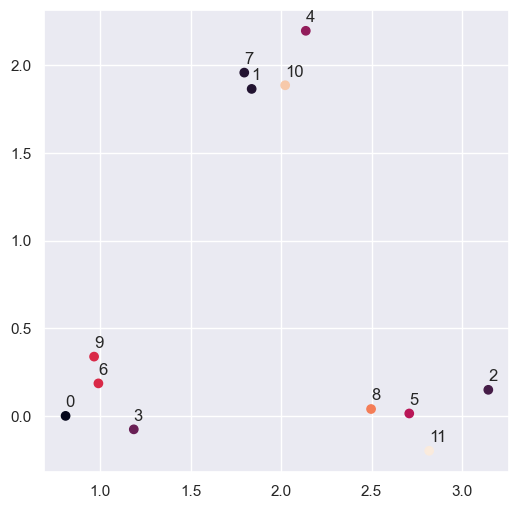

In [12]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 3

{1, 10}


,0,1,2,3,4,5,6,8,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238,1.689269,2.019802
1,2.127323,nan,2.066217,2.045245,0.330387,1.991030,1.878817,1.903930,2.228744
2,2.341675,2.066217,nan,1.972732,2.279919,0.457302,2.155771,0.657310,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737,1.316796,1.637443
4,2.563704,0.330387,2.279919,2.460712,nan,2.253036,2.193725,2.183881,2.487178
5,1.900008,1.991030,0.457302,1.525522,2.253036,nan,1.726977,0.212659,0.239403
6,0.259238,1.878817,2.155771,0.326737,2.193725,1.726977,nan,1.514366,1.868365
8,1.689269,1.903930,0.657310,1.316796,2.183881,0.212659,1.514366,nan,0.399730
11,2.019802,2.228744,0.477036,1.637443,2.487178,0.239403,1.868365,0.399730,nan


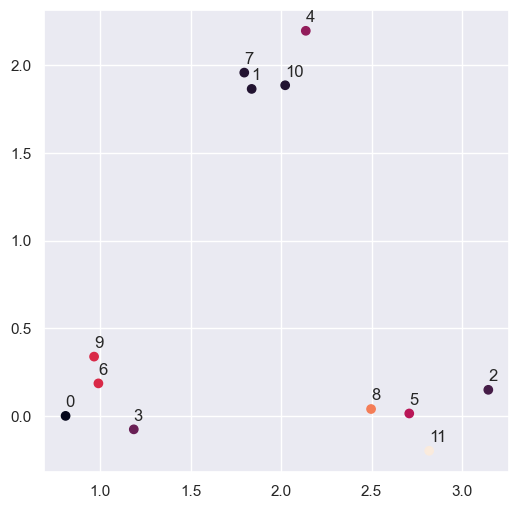

In [13]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 4

{8, 5}


,0,1,2,3,4,5,6,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.689269,0.259238,2.019802
1,2.127323,nan,2.066217,2.045245,0.330387,1.938788,1.878817,2.228744
2,2.341675,2.066217,nan,1.972732,2.279919,0.457302,2.155771,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.316796,0.326737,1.637443
4,2.563704,0.330387,2.279919,2.460712,nan,2.183881,2.193725,2.487178
5,1.689269,1.938788,0.457302,1.316796,2.183881,nan,1.514366,0.239403
6,0.259238,1.878817,2.155771,0.326737,2.193725,1.514366,nan,1.868365
11,2.019802,2.228744,0.477036,1.637443,2.487178,0.239403,1.868365,nan


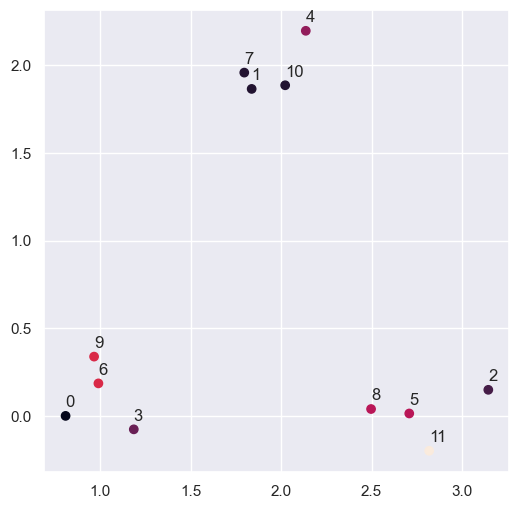

In [14]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 5

{11, 5}


,0,1,2,3,4,5,6
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238
1,2.127323,nan,2.066217,2.045245,0.330387,2.043361,1.878817
2,2.341675,2.066217,nan,1.972732,2.279919,0.457302,2.155771
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737
4,2.563704,0.330387,2.279919,2.460712,nan,2.253036,2.193725
5,1.900008,2.043361,0.457302,1.525522,2.253036,nan,1.726977
6,0.259238,1.878817,2.155771,0.326737,2.193725,1.726977,nan


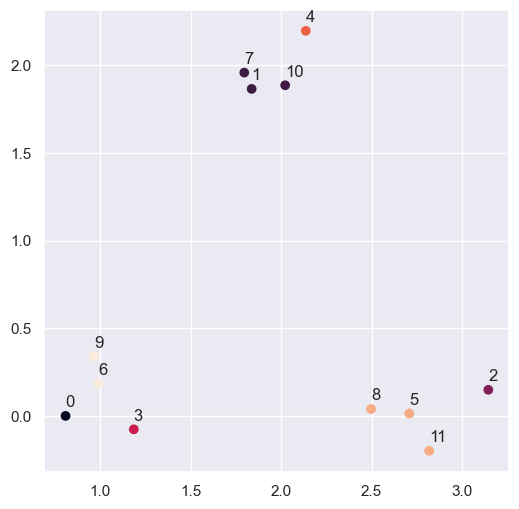

In [15]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 6

{0, 6}


,0,1,2,3,4,5
0,nan,1.878817,2.155771,0.326737,2.312120,1.726977
1,1.878817,nan,2.066217,2.045245,0.330387,2.043361
2,2.155771,2.066217,nan,1.972732,2.279919,0.457302
3,0.326737,2.045245,1.972732,nan,2.460712,1.525522
4,2.312120,0.330387,2.279919,2.460712,nan,2.253036
5,1.726977,2.043361,0.457302,1.525522,2.253036,nan


array([0, 1, 2, 3, 4, 5, 0, 1, 5, 0, 1, 5], dtype=int64)

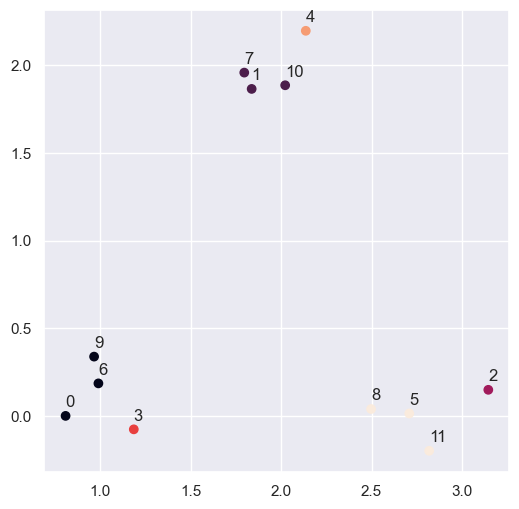

In [16]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)
cores

### Passo 7

{0, 3}


,0,1,2,4,5
0,nan,2.045245,1.972732,2.460712,1.525522
1,2.045245,nan,2.066217,0.330387,2.043361
2,1.972732,2.066217,nan,2.279919,0.457302
4,2.460712,0.330387,2.279919,nan,2.253036
5,1.525522,2.043361,0.457302,2.253036,nan


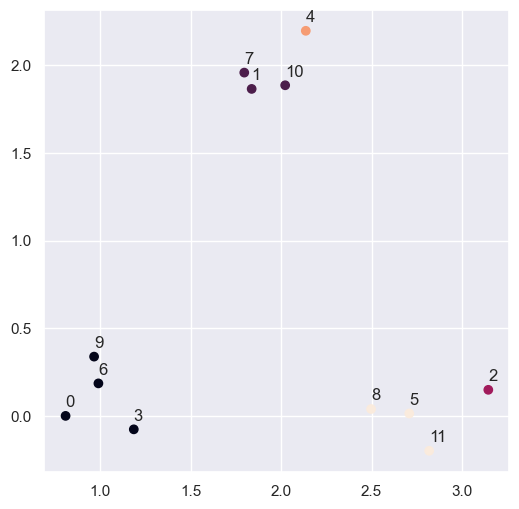

In [17]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 8

{1, 4}


,0,1,2,5
0,nan,2.127323,1.972732,1.525522
1,2.127323,nan,2.155898,2.043361
2,1.972732,2.155898,nan,0.457302
5,1.525522,2.043361,0.457302,nan


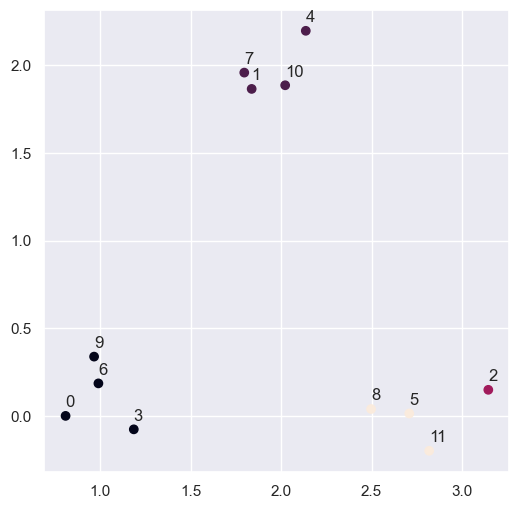

In [18]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 9

{2, 5}


,0,1,2
0,nan,2.127323,1.900008
1,2.127323,nan,2.043361
2,1.900008,2.043361,nan


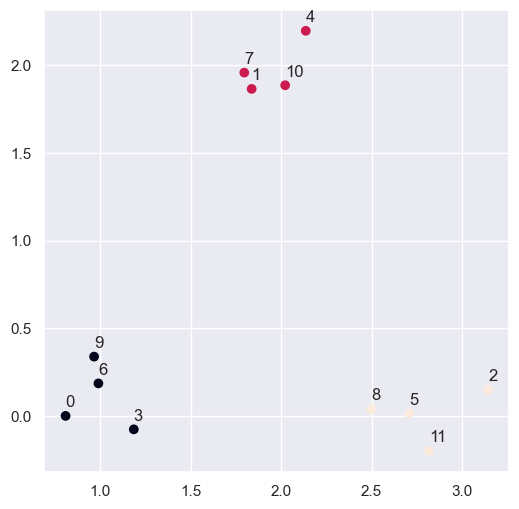

In [19]:
#juntar
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 10

{0, 2}


,0,1
0,nan,2.127323
1,2.127323,nan


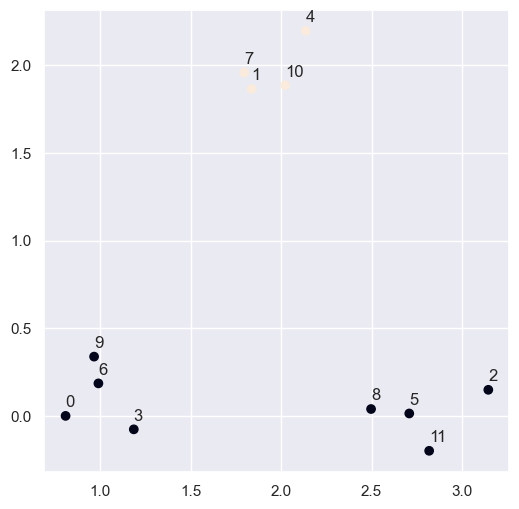

In [20]:
#juntar
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 11

{0, 1}


,0
0,nan


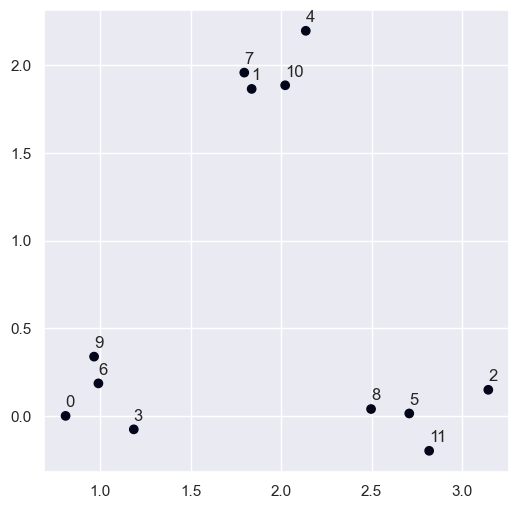

In [21]:
#juntar
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)